In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import re
import numpy as np
import pandas as pd
import unicodedata
from tqdm import tqdm
from collections import Counter

In [86]:
# np.random.seed(42) 

### Data Preprocessing

In [89]:
num_samples = 33000

In [91]:
def preprocess_sentence(sent):
    # 프랑스어 악센트 제거
    sent = ''.join(c for c in unicodedata.normalize('NFD', sent) if  unicodedata.category(c) != 'Mn')
    sent = sent.lower()
    
    # 단어와 구두점 사이 공백 생성 : 'he is a boy.' -> 'he is a boy .'
    sent = re.sub(r'([?.!,¿])', r' \1', sent)

    # (a-z, A-Z, ".", "?", "!", ",") 제외 모두 공백 처리
    sent = re.sub(r'[^a-zA-Z!.?]', r' ', sent)

    # 다수 개의 공백 하나의 공백으로 치환
    sent = re.sub(r'\s+', ' ', sent)
    return sent


def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open('./data/fra-eng/fra.txt', 'r', encoding='utf-8') as lines:
        for i, line in enumerate(lines):
            src_line, tar_line, _ = line.strip().split('\t')
            src_line = [w for w in preprocess_sentence(src_line).split()]

            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break
    return encoder_input, decoder_input, decoder_target

In [93]:
# data preprocessing test
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print(f'전처리 전 영어 문장 : {en_sent}')
print(f'전처리 후 영어 문장 : {preprocess_sentence(en_sent)}')
print(f'전처리 전 프랑스어 문장 : {fr_sent}')
print(f'전처리 후 프랑스어 문장 : {preprocess_sentence(fr_sent)}')

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [95]:
# Seq2Seq 모델은 현재 시점의 디코더에 이전 시점의 디코더 출력을 입력하나
# 해당 코드에선 sents_fr_in을 통해 이전 시점의 실제값을 현재 시점의 디코더에 입력하는 방식으로 구현
# 이전 시점의 디코더 예측이 틀린 경우 잘못된 출력값이 현재 시점의 디코더에 들어가는 것을 방지하기 위함
# 이러한 방법을 교사 강요(Teacher Forcing)라고 함

sents_en_in, sents_fr_in, sents_fr_out = load_preprocessed_data()

print(f'인코더 입력 : {sents_en_in[:5]}')
print(f'디코더 입력 : {sents_fr_in[:5]}')
print(f'디코더 라벨 : {sents_fr_out[:5]}')

인코더 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더 라벨 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


In [96]:
# vocab 생성
def build_vocab(sents):
    word_list = []

    for sent in sents:
        for word in sent:
            word_list.append(word)

    # 단어의 등장 빈도에 따라 높은 순서로 정렬
    word_counts = Counter(word_list)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)

    word_to_index = {}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK>'] = 1

    for index, word in enumerate(vocab):
        word_to_index[word] = index + 2  # pad, unk 토큰 이후로 등장 빈도 높은 단어에 index 매기기 위해 2를 더함

    return word_to_index

In [97]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fr_in + sents_fr_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)

print(f"영어 단어 집합 크기 : {src_vocab_size},  프랑스어 단어 집합 크기 : {tar_vocab_size}")

영어 단어 집합 크기 : 4486,  프랑스어 단어 집합 크기 : 7879


In [98]:
# vocab으로 정수 인코딩 진행하여 단어 -> 정수 인텍스로 변환함
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
    encoded_X_data = []
    for sent in tqdm(sents):
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])  # 들어온 단어에 대해 vocab에서 해당 단어에 대한 정수 인텍스를 찾아서 저장함
            except KeyError:
                index_sequences.append(word_to_index['<UNK>']) # 들어온 단어가 vocab에 없을 경우 UNK 토큰 인텍스로 저장함
        encoded_X_data.append(index_sequences)
    return encoded_X_data

In [103]:
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fr_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fr_out, tar_vocab)

100%|██████████| 33000/33000 [00:00<00:00, 1212290.29it/s]


In [104]:
# 인코더 입력에 대해 정수 인코딩 전 후 확인
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
    print(f'Index {i}, 정수 인코딩 전: {item1}, 정수 인코딩 후: {item2}')

Index 0, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index 1, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index 2, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index 3, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index 4, 정수 인코딩 전: ['hi', '.'], 정수 인코딩 후: [736, 2]


In [107]:
# 데이터 길이 맞추기 -> 패딩 추가
def pad_sequences(sentences, max_len=None):
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [109]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

In [111]:
print(f'encoder input shape : {encoder_input.shape}')
print(f'decoder input shape : {decoder_input.shape}')
print(f'decoder target shape : {decoder_target.shape}')

encoder input shape : (33000, 7)
decoder input shape : (33000, 16)
decoder target shape : (33000, 16)


In [113]:
# 데이터 분할 전 데이터 섞어줌
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [115]:
print([index_to_src[word] for word in encoder_input[30997]])
print([index_to_tar[word] for word in decoder_input[30997]])
print([index_to_tar[word] for word in decoder_target[30997]])

['i', 'love', 'music', '.', '<PAD>', '<PAD>', '<PAD>']
['<sos>', 'je', 'tripe', 'sur', 'la', 'musique', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['je', 'tripe', 'sur', 'la', 'musique', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [117]:
# split data -> 3,300개의 valid data
num_of_val = int(33000*0.1)

encoder_input_train = encoder_input[:-num_of_val]
decoder_input_train = decoder_input[:-num_of_val]
decoder_target_train = decoder_target[:-num_of_val]

encoder_input_test = encoder_input[-num_of_val:]
decoder_input_test = decoder_input[-num_of_val:]
decoder_target_test = decoder_target[-num_of_val:]

In [119]:
print(f'train source data shape : {encoder_input_train.shape}')
print(f'train target data shape : {decoder_input_train.shape}')
print(f'train target label shape : {decoder_target_train.shape}')
print(f'test source data shape : {encoder_input_test.shape}')
print(f'test target data shape : {decoder_input_test.shape}')
print(f'test target label shape : {decoder_target_test.shape}')

train source data shape : (29700, 7)
train target data shape : (29700, 16)
train target label shape : (29700, 16)
test source data shape : (3300, 7)
test target data shape : (3300, 16)
test target label shape : (3300, 16)


### Model

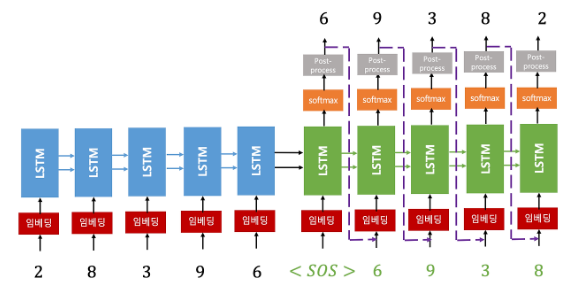

In [122]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        # x = [batch_size, sequence_len, emhedding_dim]
        x = self.embedding(x)
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell

In [124]:
class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size)

    def forward(self, x, hidden, cell):
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        output = self.fc(output)
        return output, hidden, cell

In [126]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        hidden, cell = self.encoder(src)
        output, _, _ = self.decoder(trg, hidden, cell)
        return output

In [128]:
embedding_dim = 256
hidden_units = 256

encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [130]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4486, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7879, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7879, bias=True)
  )
)

In [132]:
def evaluation(model, dataloader, loss_fn, deivce):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0
    
    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            outputs = model(encoder_inputs, decoder_inputs)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()
            
    return total_loss / len(dataloader), total_correct / total_count

In [134]:
# dataloader
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)  # 마지막 배치를 버려서 배치 크기 일정하게 유지

test_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)  # 마지막 배치를 버려서 배치 크기 일정하게 유지

In [136]:
num_epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4486, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7879, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7879, bias=True)
  )
)

In [138]:
# best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        optimizer.zero_grad()

        outputs = model(encoder_inputs, decoder_inputs)

        # batch_size, seq_len, vocab_size = outputs.shape
        # print(f"Outputs shape: {outputs.shape}")
        # print(f"Targets shape: {decoder_targets.shape}")

        loss = loss_fn(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_fn, device)
    test_loss, test_acc = evaluation(model, test_dataloader, loss_fn, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {test_loss:.4f} | Valid Acc: {test_acc:.4f}')

    # if test_loss < best_val_loss:
    #     print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}.')
    #     best_val_loss = valid_loss
    #     torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch: 1/30 | Train Loss: 2.9138 | Train Acc: 0.5319 | Valid Loss: 3.0221 | Valid Acc: 0.5289
Epoch: 2/30 | Train Loss: 2.2514 | Train Acc: 0.6057 | Valid Loss: 2.4775 | Valid Acc: 0.5967
Epoch: 3/30 | Train Loss: 1.8385 | Train Acc: 0.6514 | Valid Loss: 2.1862 | Valid Acc: 0.6260
Epoch: 4/30 | Train Loss: 1.5317 | Train Acc: 0.6883 | Valid Loss: 1.9885 | Valid Acc: 0.6491
Epoch: 5/30 | Train Loss: 1.2782 | Train Acc: 0.7258 | Valid Loss: 1.8489 | Valid Acc: 0.6656
Epoch: 6/30 | Train Loss: 1.0690 | Train Acc: 0.7608 | Valid Loss: 1.7441 | Valid Acc: 0.6826
Epoch: 7/30 | Train Loss: 0.8867 | Train Acc: 0.7963 | Valid Loss: 1.6587 | Valid Acc: 0.6937
Epoch: 8/30 | Train Loss: 0.7406 | Train Acc: 0.8251 | Valid Loss: 1.5990 | Valid Acc: 0.7029
Epoch: 9/30 | Train Loss: 0.6194 | Train Acc: 0.8521 | Valid Loss: 1.5543 | Valid Acc: 0.7124
Epoch: 10/30 | Train Loss: 0.5210 | Train Acc: 0.8743 | Valid Loss: 1.5281 | Valid Acc: 0.7130
Epoch: 11/30 | Train Loss: 0.4417 | Train Acc: 0.8895 | Val